In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_11 import *

In [3]:
import fastai.datasets as datasets
from functools import partial 

from dllib.vision.data import ImageList
from dllib.vision.cnn import xresnet18
from dllib.vision.transforms import ResizeFixed, ToByteTensor, MakeRGB
from dllib.transforms import ToFloatTensor
from dllib.data import SplitData, grandparent_splitter,\
    CategoryProcessor, label_by_func,\
    parent_labeler, get_dls, DataBunch
from dllib.loss import LabelSmoothingCrossEntropy
from dllib.optimization.optimizer import SGD
from dllib.learner import Learner
from dllib.vision.cnn import norm_imagenette
from dllib.callbacks import ProgressCallback, Recorder,\
    CudaCallback, LRFind, AvgMetric,\
    BatchTransformCallBack

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [5]:
transforms = [MakeRGB(), ResizeFixed((128,128)), ToByteTensor(), ToFloatTensor()]
il = ImageList.from_files(path, extensions=".JPEG", transforms=transforms)

sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name="val"))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
train_dl, valid_dl = get_dls(ll.train, ll.valid, 64, num_workers=8)
data = DataBunch(train_dl, valid_dl)

In [6]:
loss_func = LabelSmoothingCrossEntropy()
opt_func = SGD

In [7]:
cbfs = [ProgressCallback, CudaCallback,
        partial(BatchTransformCallBack, norm_imagenette), Recorder]

learn = Learner(xresnet18(out_channels=10), data, loss_func, lr=1, cb_funcs=cbfs, metrics=AvgMetric(accuracy))

In [8]:
learn.fit(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.9724128246307373,2.167386531829834,0.27000001072883606,25.198466539382935
1,1.5170619487762451,2.1199257373809814,0.4320000112056732,25.325387716293335
2,1.2549843788146973,1.4207407236099243,0.612000048160553,25.45413589477539
3,1.1245217323303223,1.3048357963562012,0.6620000600814819,25.562013864517212
4,1.0208420753479004,1.2067289352416992,0.7040000557899475,25.584771394729614
5,0.9354430437088013,1.3091793060302734,0.6880000233650208,25.66143560409546
6,0.8428487777709961,1.268413782119751,0.6980000138282776,25.688166856765747
7,0.7540395259857178,1.5561327934265137,0.6180000305175781,25.695467233657837
8,0.6612198352813721,1.7117462158203125,0.6220000386238098,25.7141535282135
9,0.5929837822914124,1.0081110000610352,0.8040000200271606,25.745330810546875


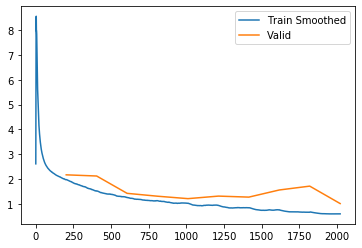

In [10]:
learn.recorder.plot_loss()